In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from argparse import Namespace
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
import numpy as np
import pandas as pd
import os
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
#!pip install konlpy
from konlpy.tag import Kkma
from konlpy.tag import Komoran

In [27]:
kkma = Komoran()

In [8]:
args = Namespace(
    source_data_path="/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter8_Seq_Modeling_Advanced/kor-eng-project/data",
    output_data_path="/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter8_Seq_Modeling_Advanced/kor-eng-project/data/ted-eng-kor.csv",
    perc_train=0.7,
    perc_val=0.15,
    perc_test=0.15,
    seed=1337
)
assert args.perc_test > 0 and (args.perc_test + args.perc_val + args.perc_train == 1.0)

In [9]:
#!pip install datasets
from datasets import load_dataset

dataset = load_dataset("msarmi9/korean-english-multitarget-ted-talks-task")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 초기화시 여기서 부터 다시 실행

In [10]:
# Train 데이터를 DataFrame으로 변환합니다.
train_df = pd.DataFrame(dataset['train'])
train_df['split'] = 'train'
# Validation 데이터를 DataFrame으로 변환합니다.
validation_df = pd.DataFrame(dataset['validation'])
validation_df['split'] = 'val'
# Test 데이터를 DataFrame으로 변환합니다.
test_df = pd.DataFrame(dataset['test'])
test_df['split'] = 'test'

In [11]:
final_df = pd.concat([train_df, validation_df, test_df], ignore_index=True)


In [12]:
final_df.head()

,korean,english,split
0,"(박수) 이쪽은 Bill Lange 이고, 저는 David Gallo입니다",(Applause) David Gallo: This is Bill Lange. I'...,train
1,우리는 여러분에게 바닷속 이야기를 영상과 함께 들려주고자 합니다.,And we're going to tell you some stories from ...,train
2,저희는 끝내주는 타이타닉 비디오도 있긴 합니다만 뭐..여기서는 눈꼽만큼도 보여줄 생...,We've got some of the most incredible video of...,train
3,(웃음) 비록 타이타닉이 박스오피스에서 굉장한 실적을 거두긴 했지만 바다가 들려주는...,(Laughter) The truth of the matter is that the...,train
4,문제라면 우리는 우리가 바다를 이미 알고있다고 믿는거죠.,"And the problem, I think, is that we take the ...",train


In [13]:
final_df["split"].value_counts()

train    166215
test       1982
val        1958
Name: split, dtype: int64

In [14]:
final_df["korean"] = final_df["korean"].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
final_df["english"] = final_df["english"].apply(lambda x: re.sub(r'\([^)]*\)', '', x))

In [15]:
def remove_person_name(text):
    # 두 어절로 된 경우
    text = re.sub(r'\b[a-zA-Z]+ [a-zA-Z]+\b:', '', text)
    # 한 어절로 된 경우
    text = re.sub(r'\b[a-zA-Z]+\b:', '', text)
    return text

# 사람 이름을 지우는 함수를 apply 메서드를 이용해 적용합니다.
final_df['korean'] = final_df['korean'].apply(remove_person_name)
final_df['english'] = final_df['english'].apply(remove_person_name)

final_df['korean'] = final_df['korean'].apply(remove_person_name)
final_df['english'] = final_df['english'].apply(remove_person_name)

In [16]:
def clean_text(text):
    # 특수문자를 제외한 문자만 남깁니다.
    text = re.sub(r'[^\.\?\!\\"\'\sa-zA-Z0-9ㄱ-힣]', '', text)
    return text

final_df['korean'] = final_df['korean'].apply(clean_text)
final_df['english'] = final_df['english'].apply(clean_text)

In [17]:
def get_length(text):
  return len(text)

In [18]:
final_df["kor_lengths"] = final_df["korean"].apply(get_length)
final_df["eng_length"] = final_df["english"].apply(get_length)

In [40]:
def remove_long_texts(df, max_length):
    text_lengths = df.apply(lambda row: len(row['korean']) + len(row['english']), axis=1)
    long_texts = df[text_lengths > max_length]
    cleaned_df = df.drop(long_texts.index, axis=0)
    return cleaned_df

def remove_kor_min_texts(df, min_length):
    kor_text_lengths = df.apply(lambda row: len(row['korean']), axis=1)
    kor_short_texts = df[kor_text_lengths <= min_length]
    df = df.drop(kor_short_texts.index, axis=0)
    return df

def remove_eng_min_texts(df, min_length):
    eng_text_lengths = df.apply(lambda row: len(row["english"]), axis=1)
    eng_short_texts = df[eng_text_lengths <= min_length]
    df = df.drop(eng_short_texts.index, axis=0)
    return df

# 최대 길이를 설정합니다.
max_text_length = 200
min_length = 1
final_df = remove_long_texts(final_df, max_text_length)
final_df = remove_kor_min_texts(final_df, min_length)
final_df = remove_eng_min_texts(final_df, min_length)

<Axes: xlabel='kor_lengths', ylabel='Count'>

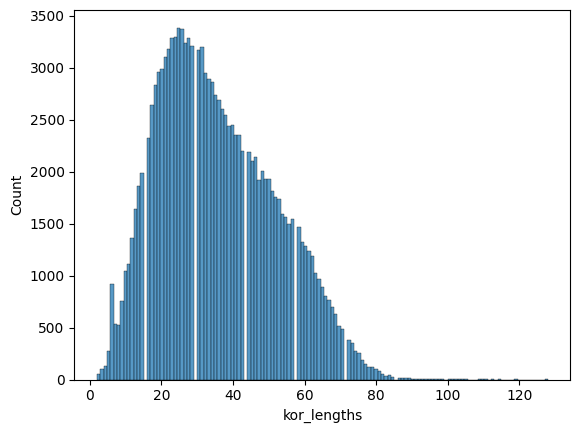

In [41]:
import seaborn as sns

sns.histplot(data=final_df, x="kor_lengths")

<Axes: xlabel='eng_length', ylabel='Count'>

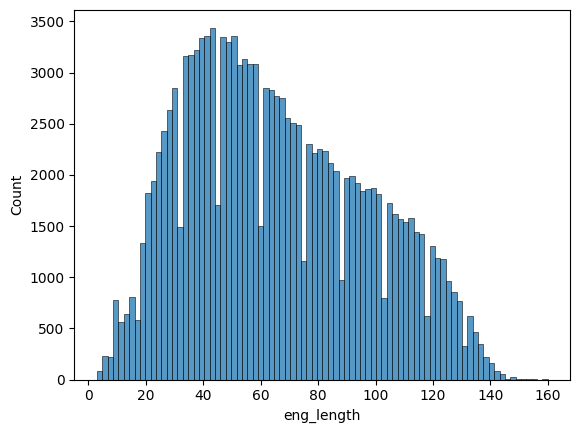

In [42]:
sns.histplot(data=final_df, x="eng_length")

In [34]:
final_df.split.value_counts()

train    130826
test       1684
val        1603
Name: split, dtype: int64

In [48]:
def eng_tokenize(text):
  text = " ".join(word_tokenize(text))
  return text

def kor_tokenize(text):
  text = " ".join(kkma.morphs(text))
  return text

In [49]:
from tqdm.notebook import tqdm

# tqdm을 사용하여 apply 함수를 모니터링합니다.
tqdm.pandas()

# apply 함수를 사용하여 한국어 텍스트를 토큰화하고 tqdm으로 모니터링합니다.
final_df['korean'] = final_df['korean'].progress_apply(kor_tokenize)
final_df["english"] = final_df["english"].progress_apply(eng_tokenize)

  0%|          | 0/134092 [00:00<?, ?it/s]

  0%|          | 0/134092 [00:00<?, ?it/s]

In [50]:
# 숫자를 <NUM>으로 대체하는 함수를 정의합니다.
def replace_numbers(text):
    return re.sub(r'\b\d+\b', '<NUM>', text)

final_df['korean'] = final_df['korean'].apply(replace_numbers)
final_df['english'] = final_df['english'].apply(replace_numbers)

In [54]:
def count_tokens(text):
    return len(text.split())

In [55]:
final_df["kor_token_lengths"] = final_df["korean"].apply(count_tokens)
final_df["eng_token_lengths"] = final_df["english"].apply(count_tokens)

<Axes: xlabel='kor_token_lengths', ylabel='Count'>

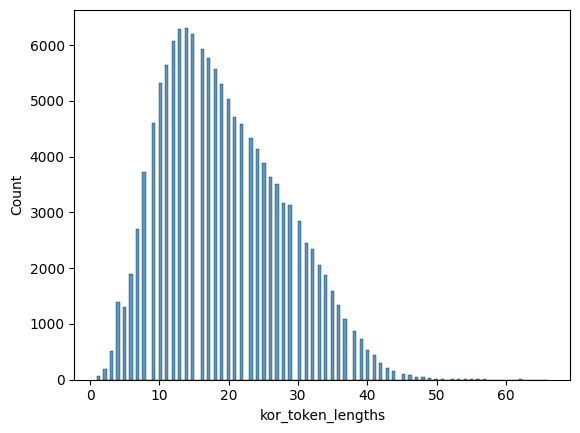

In [56]:
sns.histplot(data=final_df, x="kor_token_lengths")

<Axes: xlabel='eng_token_lengths', ylabel='Count'>

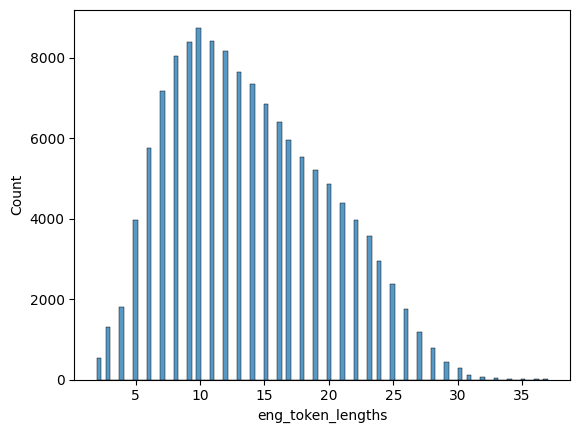

In [58]:
sns.histplot(data=final_df, x="eng_token_lengths")

In [59]:
final_df.kor_token_lengths.max()

66

In [61]:
final_df.eng_token_lengths.max()

37

In [62]:
final_df.tail(n=5)

,korean,english,split,kor_lengths,eng_length,kor_token_lengths,eng_token_lengths
170149,아직 <NUM> 살 에 불과 하 지만 당신 이 생각 하 는 좀 더 미래 의 당신 은...,And as you think of your life going forward yo...,test,63,122,33,25
170150,예 . 에너지 와 관련 하 ㄴ 일 하 ㄹ 생각 을 갖 고 있 습니다 .,Yeah . I 'm still thinking to work on energy .,test,28,44,17,11
170151,윌리엄 TED 에 당신 을 초대 하 게 되 어 영광 이 ㅂ니다 .,Wow . William it 's a real honor to have you a...,test,28,66,14,16
170152,오 아 주 어서 정말 고마워요 .,Thank you so much for coming .,test,12,29,7,7
170153,감사 하 ㅂ니다 .,Thank you .,test,7,11,4,3


In [65]:
final_df = final_df[["korean", "english", "split"]]

In [66]:
final_df.head()

,korean,english,split
0,이쪽 은 Bill Lange 이고 저 는 David Gallo 이 ㅂ니다,This is Bill Lange . I 'm Dave Gallo .,train
1,우리 는 여러분 에게 바닷속 이야기 를 영상 과 함께 들려주 고자 하 ㅂ니다 .,And we 're going to tell you some stories from...,train
2,저희 는 끝내 어 주 는 타이타닉 비디오 도 있 기 ㄴ 하 ㅂ니다만 뭐 .. 여기 ...,We 've got some of the most incredible video o...,train
4,문제 이 라면 우리 는 우리 가 바다 를 이미 알 고 있 다고 믿 는 거 죠 .,And the problem I think is that we take the oc...,train
5,보통 바다 가 지구의 <NUM> 를 감싸 고 있 다는 것,When you think about it the oceans are <NUM> p...,train


In [67]:
final_df = final_df[["english", "korean", "split"]]

In [68]:
final_df = final_df.rename(columns={'english': 'source_language'})
final_df = final_df.rename(columns={'korean': 'target_language'})

In [70]:
final_df.to_csv(args.output_data_path)

In [71]:
final_df.head()

,source_language,target_language,split
0,This is Bill Lange . I 'm Dave Gallo .,이쪽 은 Bill Lange 이고 저 는 David Gallo 이 ㅂ니다,train
1,And we 're going to tell you some stories from...,우리 는 여러분 에게 바닷속 이야기 를 영상 과 함께 들려주 고자 하 ㅂ니다 .,train
2,We 've got some of the most incredible video o...,저희 는 끝내 어 주 는 타이타닉 비디오 도 있 기 ㄴ 하 ㅂ니다만 뭐 .. 여기 ...,train
4,And the problem I think is that we take the oc...,문제 이 라면 우리 는 우리 가 바다 를 이미 알 고 있 다고 믿 는 거 죠 .,train
5,When you think about it the oceans are <NUM> p...,보통 바다 가 지구의 <NUM> 를 감싸 고 있 다는 것,train
